# Module 4 – Episode 15: Data Cleaning & Feature Engineering

In this notebook you’ll **clean, validate, and enrich** raw geospatial data – the essential first step before any meaningful urban‑mobility analysis.

Remember: *garbage‑in, garbage‑out*. Even the best tools can’t rescue messy input.

In [2]:
# Install required libraries
!pip install geopandas contextily geopy osmnx --quiet

## 1 · Geocoding addresses with Nominatim + Geopy
In real datasets, locations may appear as addresses instead of lat/long.  Below we convert the address of **Camp Nou Stadium Stadium** (Barcelona) into coordinates.

In [8]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='geo_example')
address = 'Camp Nou Stadium, Spain'
location = geolocator.geocode(address)
print(f'Latitude: {location.latitude}, Longitude: {location.longitude}' )

Latitude: 41.3808806, Longitude: 2.1228182


## 2 · Detect missing coordinates
After geocoding, always validate: are any rows still missing lat/long?

In [9]:
import pandas as pd
# Sample dataset with one missing coordinate row
data = {
    'ID': [1, 2, 3],
    'LATITUD': [41.1579, None, 41.1496],
    'LONGITUD': [-8.6291, -8.6110, -8.6155]
}
df = pd.DataFrame(data)
missing_coords = df[df['LATITUD'].isna() | df['LONGITUD'].isna()]
print(f'Rows with missing coordinates: {len(missing_coords)}')
df

Rows with missing coordinates: 1


,ID,LATITUD,LONGITUD
0,1,41.1579,-8.6291
1,2,NaN,-8.6110
2,3,41.1496,-8.6155


## 3 · Remove incomplete rows (simple strategy)
A common strategy in this case would be to remove the row with missing data.

In [10]:
df_cleaned = df.dropna(subset=['LATITUD', 'LONGITUD']).copy()
df_cleaned

,ID,LATITUD,LONGITUD
0,1,41.1579,-8.6291
2,3,41.1496,-8.6155


## 4 · Visual inspection – raw points vs. city boundary

(np.float64(209679.41415426123),
 np.float64(249887.01791934908),
 np.float64(5056370.918672171),
 np.float64(5118992.741027987))

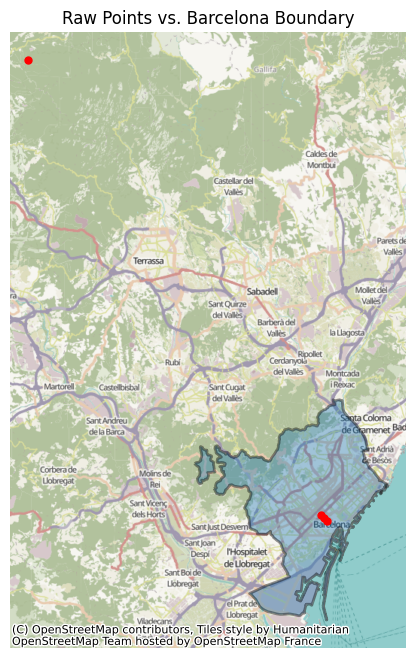

In [20]:
import geopandas as gpd, osmnx as ox, contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Barcelona boundary
gdf_boundary = ox.geocode_to_gdf('Barcelona, Spain')

# Four sample points (one outside Barcelona)
pts_data = {
    'name': ['Point 1', 'Point 2', 'Point 3', 'Outside Point'],
    'lat':  [41.387, 41.385, 41.389, 41.7],
    'lon':  [2.170, 2.173, 2.168, 1.9]
}
df_pts = pd.DataFrame(pts_data)
gdf_pts = gpd.GeoDataFrame(df_pts,
                          geometry=[Point(xy) for xy in zip(df_pts.lon, df_pts.lat)],
                          crs='EPSG:4326')

# Reproject
gdf_boundary = gdf_boundary.to_crs(epsg=3857)
gdf_pts = gdf_pts.to_crs(epsg=3857)

ax = gdf_boundary.plot(figsize=(8,8), alpha=0.4, edgecolor='black', linewidth=2)
gdf_pts.plot(ax=ax, color='red', markersize=25)
ctx.add_basemap(ax)
ax.set_title('Raw Points vs. Barcelona Boundary')
ax.axis('off')

## 5 · Spatial filter – keep only points inside city

(np.float64(227504.1787809639),
 np.float64(249038.21960379183),
 np.float64(5058097.947436741),
 np.float64(5082725.136972032))

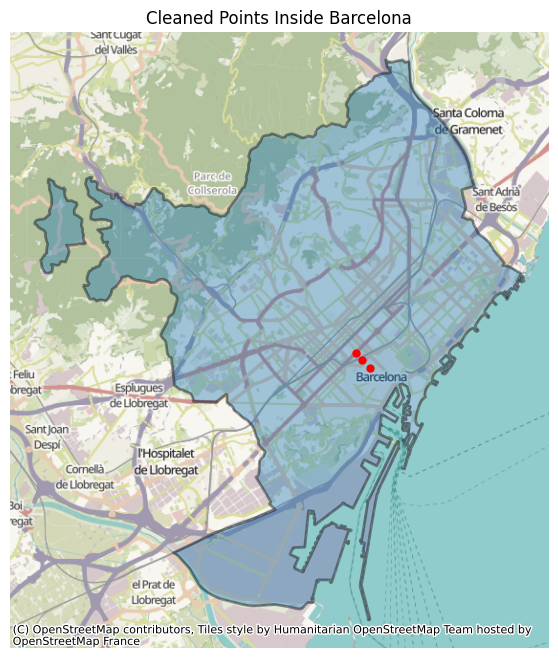

In [19]:
gdf_clean = gdf_pts[gdf_pts.within(gdf_boundary.loc[0,'geometry'])].copy()

ax = gdf_boundary.plot(figsize=(8,8), alpha=0.4, edgecolor='black', linewidth=2)
gdf_clean.plot(ax=ax, color='red', markersize=25)
ctx.add_basemap(ax)
ax.set_title('Cleaned Points Inside Barcelona')
ax.axis('off')

## Summary
In this episode, you learned how to clean, validate, and enrich raw geospatial data — a critical step before any urban mobility analysis.

You used `Geopy` to geocode address-based locations, checked for missing coordinates, and applied a basic cleaning strategy by removing incomplete rows.  
You also validated your data spatially by comparing raw point locations against the official city boundary of Barcelona, using `OSMnx`, `GeoPandas`, and `Contextily`.

These techniques help ensure your data is accurate, complete, and within the expected study area — avoiding “garbage in, garbage out” scenarios in spatial modeling.